In [3]:
import os
import numpy as np
import pickle

# Binary matrix

In [4]:
'''
This script is able to build a coocurence matrix from a list of COG of an organism.
It needs to take a csv file containing the list of the COG and the directory where the
COG files are stored.
It returns a numpy array.
'''
def iter_query_cog(query_orth):
    with open(query_orth) as csvfile:
        next(csvfile)
        for l in csvfile:
            buffer = l.split(';')
            yield([buffer[4],buffer[5]])

def cog_2_g_list(cog_id,cog_dir):
    file_path = f'{cog_dir}/COG_{cog_id}.csv'
    g_list = list()
    with open(file_path) as csvfile:
        next(csvfile)
        for l in csvfile:
            buffer = l.split(',')
            strain = buffer[1]
            g_list.append(strain)
    return g_list

def p_dict_builder(query_orth,cog_dir):
    p_dict={}
    i=0
    for cog_id,p_name in iter_query_cog(query_orth):
        g_list = cog_2_g_list(cog_id,cog_dir)
        p_dict[p_name] = g_list
        #i=i+1
        #if i>9:
            #break
    return p_dict

def index_setter(p_dict):
    p_index = list()
    g_index = set()
    for p_name,g_list in p_dict.items():
        p_index.append(p_name)
        g_index.update(g_list)
    g_index = list(g_index)
    return p_index,g_index

def set_M_values(M,m_index,g_name,p_name,value): 
    i = m_index[0].index(p_name) #protein index
    j = m_index[1].index(g_name) #genome index
    M[i,j] = value

def matrix_builder(query_orth,cog_dir,value):
    #generate a dictionnary of protein coocurences
    p_dict=p_dict_builder(query_orth,cog_dir)
    with open('p_dict.pkl', 'wb') as file:
        pickle.dump(p_dict, file)
    #generate the coocurences matrix index
    m_index=index_setter(p_dict)
    with open('m_index.pkl', 'wb') as file:
        pickle.dump(m_index, file)
    #generate the coocurences matrix
    x = len(m_index[0])
    y = len(m_index[1])
    M = np.zeros((x,y))
    for p_name,g_list in p_dict.items():
        for g_name in g_list:
            set_M_values(M,m_index,g_name,p_name,value)
    with open('p_matrix.npy', 'wb') as f:
        np.save(f, M)
    return M

To build a binary matrix use the matrix builder function.
Feed it with a csv file listing the ortholog associated to your strain query "query_orth"
and a directory containing all the COG groups "cog_dir".
Set the value to "1".

In [5]:
%%time
query_orth ='/Users/mdupuy/Documents/Stage/Pseudomonas_aeruginosa_PA7_119_ortholog_groups.csv'
#query_orth = 'Data/COG/Pseudomonas_aeruginosa_PA7_119_ortholog_groups.csv'
cog_dir ='/Users/mdupuy/Documents/Stage/All_COG_groups/'
#cog_dir='Data/COG/All_COG_groups/'
binary_matrix = matrix_builder(query_orth,cog_dir,1)

CPU times: user 4min 17s, sys: 5.49 s, total: 4min 22s
Wall time: 6min 52s


# Score Matrix

In [4]:
'''
This script is able to build a coocurence matrix from a list of protein alignment score
from sevaral organism against a query one.
It needs to take txt files containing alignment score information.
It returns a numpy array.
'''
def score_p_dict_builder(score_file_dir):
    path = score_file_dir
    dico_prot={}
    for file in os.listdir(path):
        dico_strain={}
        protein = file.strip('_scores.txt')
        file_path = f'{path}{file}'
        with open(file_path,'r') as file:
            for l in file:
                buffer = l.split(',')
                strain = buffer[2]
                score = buffer[3].strip('\n')
                dico_strain[strain]=score
        dico_prot[protein]=dico_strain
    return(dico_prot)        

def score_matrix_builder(score_file_dir,title):
    if not os.path.isfile(f'p_dict_{title}.pkl'):
        p_dict = score_p_dict_builder(score_file_dir)
        with open(f'p_dict_{title}.pkl', 'wb') as file:
            pickle.dump(p_dict, file)
    else:
        with open(f'p_dict_{title}.pkl', 'rb') as file:
            p_dict = pickle.load(file)
    if not os.path.isfile(f'm_index_{title}.pkl'):
        m_index = index_setter(p_dict)
        with open(f'm_index_{title}.pkl', 'wb') as file:
            pickle.dump(m_index, file)
    else:
        with open(f'm_index_{title}.pkl', 'rb') as file:
            m_index = pickle.load(file)
    x = len(m_index[0])
    y = len(m_index[1])
    M = np.zeros((x,y))
    for p_name,g_list in p_dict.items():
            for g_name in g_list:
                i = m_index[0].index(p_name) #protein index
                j = m_index[1].index(g_name) #genome index
                M[i,j] = p_dict[p_name][g_name]
    #if not os.path.isfile(f'p_matrix_{title}.npy'):
        #with open(f'p_matrix_{title}.npy', 'wb') as f:
            #np.save(f, M)
    #else:
        #with open(f'p_matrix_{title}.npy', 'rb') as f:
            #M = np.load(f,allow_pickle=True)
    return(M)

To build a score matrix use the score_matrix_builder function.
Feed it with directory containing all the alligment socre data "score_file_dire".
Define a title.

In [14]:
%%time
score_file_dir = 'Data/Score/'
score_matrix = score_matrix_builder(score_file_dir,'score')

CPU times: user 6min 34s, sys: 4.69 s, total: 6min 39s
Wall time: 7min 29s


# KEGG Matrix

In [18]:
'''
This script is able to build a pathway*protein matrix from a list of pathway.
It needs to take txt files containing pathway information.
It returns a numpy array.
'''
from bioservices import KEGG

def iter_pathway(list_pathway):
    with open(list_pathway) as file:
        for l in file:
            if l.strip():
                buffer = l.split()
                yield(buffer[0])
                
def KEGG_request():
    k = KEGG(verbose=False)
    problematic_pathway = []
    for pathway in iter_pathway(list_pathway):
        res = k.get(f"path:{pathway}")
        d = k.parse(res)
        with open(f"{pathway}.txt","w") as file:
            if 'GENE' in d.keys():
                for gene in d['GENE']:
                    file.write(f'{gene}\n')
            else:
                file.write('gene not found')
                problematic_pathway.append(path)
                continue
            
def pathway_dict_builder(list_pathway,path):
    dico = {}
    list_pathway = f'{path}{list_pathway}'
    for pathway in iter_pathway(list_pathway):
        file_path = f'{path}{pathway}.txt'
        protein = []
        with open(file_path) as file:
            for l in file:
                protein.append(l.strip('\n'))
        dico.setdefault(pathway,[]).extend(protein)  
    return(dico)

def kegg_matrix_builder(list_pathway,path):
    pathway_dict = pathway_dict_builder(list_pathway,path)
    m_index = index_setter(pathway_dict)
    x = len(m_index[0])
    y = len(m_index[1])
    M = np.zeros((x,y))
    for p_name,g_list in pathway_dict.items():
        for g_name in g_list:
            i = m_index[0].index(p_name) #protein index
            j = m_index[1].index(g_name) #genome index
            M[i,j] = 1
    return M

To build a KEGG Matrix use the kegg_matrix_builder function. Feed it with a directory containing file describing pathway and the list of pathway.

In [ ]:
path = 'Data/KEGG/'
list_pathway = 'List_126_KEGG_Path_PA7.txt'
kegg_matrix = kegg_matrix_builder(list_pathway,path)

#  Transformation

In [47]:
import matplotlib.pyplot as plt
def svd(M,threshold):
    '''
    Apply the svd method to a score profile matrix to reduce it noise according to a
    certain threshold
    '''
    M_xmax = np.amax(M,axis=1)
    M_lnorm = np.divide(M.T,M_xmax).T
    print("first normalisation")
    u, s, vh = np.linalg.svd(M_lnorm, full_matrices=False)
    s[threshold:]=0.0
    P = np.dot(u * s, vh)
    print("svd")
    P_norm = np.linalg.norm(P,keepdims=True,axis=0)
    P_u = np.divide(P,P_norm)
    print("second normalisation")
    print("done")
    return P_u

In [56]:
def npp(M):
    '''
    Apply the npp methode to a score profile matrix
    '''
    M=score_matrix
    # corrige les valeurs à 0 pour prévenir les artefact
    minval = np.min(M[np.nonzero(M)])
    score_matrix[score_matrix==0]=minval
    # normalisation par la taille
    M_xmax = np.amax(M,axis=1)
    M_lnorm = np.divide(M.T,M_xmax).T
    # transformation monotonique
    M_transf = np.reciprocal(M_lnorm)
    # z-score
    M_ymean = np.mean(M_transf,axis=0,keepdims=True)
    M_ystd = np.std(M_transf,ddof=0,axis=0,keepdims=True)
    M = np.divide(np.subtract(M,M_ymean),M_ystd)
    return M

# Distance matrix

In [7]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
def distance_matrix_builder(coocurencies_matrix,metric):
    '''
    the metric use to calculate the distance can be:
    - 'hamming' for binary matrix, 
    - 'euclidean' and 'correlation' for score matrix
    '''
    if not os.path.isfile(f'{metric}_distance_matrix.pkl'):
        distance = pdist(coocurencies_matrix, metric=metric)
        distance_matrix = squareform(distance)
        with open(f'{metric}_distance_matrix.pkl', 'wb') as f:
            pickle.dump(distance_matrix,f)
    else:
        with open(f'{metric}_distance_matrix.pkl', 'rb') as file:
            distance_matrix = pickle.load(file)
    return distance_matrix

To calculate the distance between pairwise protein use distance_matrix_builder. Feed it with coocurencies_matrix
and use a metric such as 'hamming', 'euclidean' or 'correlation'

In [8]:
binary_distance_matrix = distance_matrix_builder(binary_matrix,'hamming')
#score_distance_matrix = distance_matrix_builder(score_matrix,'euclidean')

# Test de précision

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import random
def df_intersect(df):
    print('intersecting')
    distance_matrix = df
    observed_adjency = pd.read_pickle('Data/Result/pkl/observed_adjency_matrix.pkl')

    d_ind = distance_matrix.index

    o_ind = observed_adjency.index

    ind = d_ind.intersection(o_ind)

    distance_matrix = distance_matrix.reindex(index=ind, columns=ind)

    #dico = distance_matrix.to_dict('split')
    print('intersected')
    return distance_matrix

def get_couples(index_list):
    for i in range(len(index_list)):
        for j in range(i+1,len(index_list)):
            yield((index_list[i],index_list[j]))

def couple_sorter(df):
    print('sorting')
    couple_dist={}
    dico = df.to_dict('split')
    for couple in get_couples(dico['index']):
        dist=df.loc[couple]
        couple_dist.setdefault(dist,[]).append(couple)
    couple_dist_ord = dict(sorted(couple_dist.items(),reverse=False))
    #print(couple_dist_ord)
    print('sorted')
    return couple_dist_ord

def courbe_rc(dico,shuffle):
    print('ploting')
    observed_adjency = pd.read_pickle('Data/Result/pkl/observed_adjency_matrix.pkl')
    P_list = []
    TP = 0
    FP = 0
    n = 1
    value_list = list(dico.values())
    if shuffle == True:
        random.shuffle(value_list)
    for value in value_list:
        for couple in value:
            if (observed_adjency.loc[couple[0],couple[1]]) == 1:
                TP = TP+1
            else:
                FP = FP+1
            n=n+1
            if n==1000:
                Precision = TP/(TP+FP)
                P_list.append(Precision)
                n = 1
    print('ploted')
    return P_list

def benchmark(list_path):
    dico_rc = {}
    for path in list_path:
        distance_matrix = pd.read_pickle(path)
        intersect_matrix = df_intersect(distance_matrix)
        couple_dist = couple_sorter(intersect_matrix)
        rc_ord = courbe_rc(couple_dist, False)
        dico_rc[path] = rc_ord
    rc_rand = courbe_rc(couple_dist, True)
    dico_rc['rand'] = rc_rand
    return dico_rc

In [58]:
M = npp(score_matrix)

In [10]:
#dist_matrix = distance(M,'euclidean')
import pandas as pd
import pickle
with open('m_index.pkl','rb') as file:
    mynewlist = pickle.load(file)
    p_list = mynewlist[0]
df = pd.DataFrame(binary_distance_matrix)
df.index = p_list
df.columns = p_list
df.to_pickle('test_binary_h.pkl')

intersecting
intersected
sorting
sorted
ploting
ploted
ploting
ploted


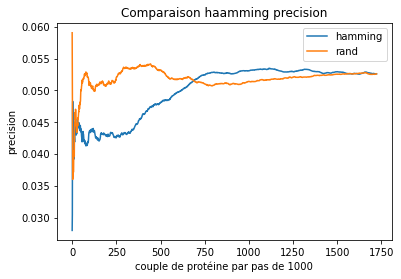

In [17]:
dico_rc = benchmark(['test_binary_h.pkl'])
plt.plot(dico_rc['test_binary_h.pkl'],label='hamming')
plt.plot(dico_rc['rand'],label='rand')
plt.legend()
plt.title('Comparaison haamming precision')
plt.xlabel('couple de protéine par pas de 1000')
plt.ylabel('precision')
plt.savefig('Comparaison hamming precision.png',dpi=200)

# Ideas

In [29]:
'''
Test to determine TP,FP,TN and FN in a more appropriate way

1 - generate a set of list of every protein couple per distance
2 - generate a set of list of every protein couple per KEGG pathway
3 - set a threshold which split the first set in two, couple bellow the threshold are
gathered as positive, couple above the threshold as negative.
4 - intersect the postive set with the KEGG set, the len of the return list correspond to
the number of true positive (TP)
5 - the len of the positive set minus the number of true positive correspond to the false
positive (FP)
6 - intersect the negative set with the KEGG set, the len of the return list correspond to
the number of false negative (FN)
7 - the len of the negative set minus the number of false negative correspond to the true
negative (TN)
8 - calculate recall and precision
9 - change the threshold repeat
10 - plot the recall/precision graph
'''
import itertools as it

path = 'Data/KEGG/'
list_pathway = 'List_126_KEGG_Path_PA7.txt'
kegg_dico = pathway_dict_builder(list_pathway,path)
kegg_couple = set()
for value in kegg_dico.values():
    kegg_couple.update(it.combinations(value,2))
print(len((kegg_couple)))

96500
